What is in scope:

Following something similar to bayesian cart to search over features. 

We will use linear svm accuracy over randomly generated data to determine whether our representation is an improvement or not

The goal of this topic is to determine the ideal projection when the dimensions of the input may vary (in columns). The dimensions of the columns are determined by feature generation/embeddings. 

Let:

*  $W$ be the projection matrix
*  $X$ to be the matrix representing input data which may vary in dimension from iteration to iteration
*  $Y$ be the result of the projection, i.e. $WX = Y$

WLOG fix the size of $Y$, (let's call this $d$). Then we have $W \in \mathbb{R}^{d \times n}$.

In this setting within the RJMCMC framework, the number of parameters we are estimating is:

*  all entries in $W$ ($d \times n$)  
*  all relevant combination of feature generation functions and their respective parameters 
                                             

### Examples of feature vector generation functions

As an example of an algorithm which we should compare is the multivariate adaptive regression splines (MARS)

**Hinge Function**

The hinge function ($f_\text{hinge}$) is similiar to ReLu), can be defined as a feature generation function, (_probably not the right way to write this out_)

$$ f_{\text{hinge}^+} (X_{j}, \theta) = (X_j-\theta \mathbf{1})_{+}$$

Where $X_j$ represents the $j$th column, without loss of generality we can likewise define $f_{\text{hinge}^-} (X_{j}, \theta) = (\theta \mathbf{1} - X_j)_{+}$

**Interaction**

Interaction term will be defined the dot product of two feature vectors (which can be the same feature vector), (_probably not the right way to write this out_)

$$ f_\text{interaction} (X_1, X_2) = X_1  \cdot X_2 $$

Replicating MARS in RJMCMC
--------------------------

[MARS](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines) is a prime candidate for exploring this problem. 

In the RJMCMC space we have the following decisions:

1. GROW - we can grow the state by Proposing a new feature vector generation transformation and respective parameter, e.g. hinge, interaction, or more complex function transforms which could be a composition of function generation...
2. DESTROY - we can also delete a created feature

This would be represent moving from one state to another.                                  

In [1]:
import numpy as np
import pandas as pd

from hinge import Hinge, error_on_split
from interaction import Interaction

from sklearn import datasets
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# using svm as per scikit-feature repo
from sklearn.decomposition import FactorAnalysis # we shall use factor analysis to fix the size of final modelling ds.
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# for sampling
import random # use random.choice? and random.sample for interactions

# use networkx to keep track of changes to our data, so we can recreate things...
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_classification

problem_setup = {
    'n_samples': 300, 
    'n_features': 50, 
    'n_informative': 10, 
    'n_redundant': 10, 
    'n_classes': 3, 
    'random_state': 0    
}

X, y = make_classification(**problem_setup)
X = X.astype(float)
n_samples, n_features = X.shape    # number of samples and number of features



In [3]:
import pandas as pd # for making sure and exploring created datasets...
X_df = pd.DataFrame(X)
base_names = ["base_{}".format(x) for x in range(n_features)]
X_df.columns = base_names[:]
X_df.head()

,base_0,base_1,base_2,base_3,base_4,base_5,base_6,base_7,base_8,base_9,...,base_40,base_41,base_42,base_43,base_44,base_45,base_46,base_47,base_48,base_49
0,0.140673,-1.056507,0.211336,-0.051245,-1.707436,0.812612,0.529927,0.337739,-0.010239,5.082635,...,-2.159166,-0.505031,-0.290300,-1.423013,-3.531133,-0.074873,-2.908971,-0.533449,0.512048,-1.315979
1,1.734870,1.749369,0.393464,0.148533,-1.712113,-0.199287,-0.667767,-0.943495,0.681635,10.447742,...,-0.558268,-7.479695,-1.706696,-1.395395,0.973802,-1.041347,-6.201191,-1.176442,0.944423,0.898251
2,-5.493219,-2.420378,1.699525,0.362889,2.864180,-0.716517,0.473016,-2.715607,-1.177175,1.574229,...,-1.303525,1.311686,-0.583548,-0.007803,-0.151316,-0.385398,-3.257219,1.409357,-2.276589,-0.894274
3,2.791666,-0.639234,-0.763891,1.370567,-5.788661,-0.260745,1.800210,-1.234377,-1.453207,-1.568038,...,2.405260,-1.256116,-0.726343,-0.655469,4.565850,-0.863371,0.646507,1.113179,3.217174,-1.646719
4,3.785220,-0.750653,1.519439,-0.643260,-11.617471,0.649915,-2.345340,2.838290,-0.866542,-0.351528,...,1.227032,-0.983323,-1.639763,0.144169,0.267208,1.068478,-4.026710,-2.084032,4.185424,-0.085756


In [4]:
def eval_pipeline(additional_feats=[], X=X_df, y=y, verbose=True):
    pipeline = additional_feats[:]
    pipeline.append(('factor analysis', FactorAnalysis(20)))
    pipeline.append(('linear svm', LinearSVC()))
    model = Pipeline(pipeline[:])

    # split data into 10 folds
    kfold = KFold(n_splits=3, shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold)
    if verbose:
        print("Accuracy: {}".format(results.mean()))
    return results.mean()

In [5]:
# baseline solution - vanilla pipeline
eval_pipeline(X=X_df)

Accuracy: 0.7033333333333335


0.70333333333333348

Feature Search
=======

We have 4 possible situations:

1. Grow - split : assumption is we always grow 2
2. Grow - interaction
3. Remove - split : assumption is we always destroy both
4. Remove - interaction

Proposal Distributions
------------------------

Assume each action has equal probability and is uniform

### Splits

**Grow (Split) | Base (Remove) **

We will use the same probability of split as given in Bayesian cart: $p_{\text{split}}(X_i) = \alpha(1+\text{total_splits})^{-\beta}$
where $\text{total_splits}$ represents the total number of times a node has been created for column $X_i$. Then

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \alpha(1+\text{total_splits})^{-\beta} $$ 

----

For now we will make it simple, and say if it is chosen it will always split.

This would be...

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \frac{1}{\text{candidate children nodes}} $$ 

**Base (Remove) | Grow (Split)**

This should be the same as drawing based on number of additional features created (call this $n$). 

$$P(\text{ Base (Remove) } | \text{ Grow (Split) }) = (\frac{1}{4}  \frac{2}{n}) \times (\frac{1}{4}  \frac{1}{n-1}) = \frac{1}{8}  \frac{1}{n(n-1)}$$

----


For now we will make it simple, and say if it is chosen it will always split.

This would be...

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \frac{1}{\text{candidate parent nodes}} $$ 

Note that the parent nodes chosen here can only be one level up from the terminal node....

### Interaction

**Grow (Interaction) | Base (Interaction)**

This again is your binomial draws, this one is based on total number of features, which we will denote by $d + n$, i.e. original size of your dataset and the total number of generated features. 

$$P(\text{ Grow (Interaction) } | \text{ Base (Interaction) }) = \frac{1}{4} \frac{2}{(d+n)(d+n-1)} = \frac{1}{2} \frac{1}{(d+n)(d+n-1)}$$

Note that anything can have interaction! So we can't presume as above - we should somehow also exclude previously created interactions!

Can be more simply

$$P(\text{ Grow (Interaction) } | \text{ Base (Interaction) }) = \frac{1}{4} \frac{1}{\text{candidate interaction pairs}}$$

**Base (Interaction) | Grow (Interaction)**

This is just choosing one particular feature that is created.

$$P(\text{ Base (Interaction) } | \text{ Grow (Interaction) }) = \frac{1}{4} \frac{1}{\text{candidate interaction parents}}$$


------

In this setting there is no need for RJMCMC (yet) as the transformations are parameter free.

What this means is we can do a straight MH

In [6]:
# our proposal distributions

def split_given_remove(num_splits):
    # make this simplier for now...
    #return 0.25 * alpha * ((1.0+num_splits)^(-beta))
    return 0.25 * num_splits
    

def remove_given_split(num_created):
    # num created is the number of base spllits, we can possibly 
    # remove!
    #return 0.125 * (1.0/(num_created*(num_created-1)))
    return 0.25 * num_created

def interact_given_remove(base_dim, num_created):
    from scipy.misc import comb
    total_dim = base_dim + num_created
    return 0.5 * (1.0/(total_dim * (total_dim - 1)))

def remove_given_interact(num_created):
    return 0.25*num_created

In [7]:
"""
each model proposal can be represented by a dictionary
so the markov chain will be a list of dictionaries

Sample usage:

ds_pipeline = [
    ('hinge', Hinge()), 
    ('interaction', Interaction([1,2]))
    ]

eval_pipeline(ds_pipeline)
"""

def get_name(name):    
    clean_name = name.split("_")
    return clean_name




In [8]:
def graph_to_dict(G):
    return dict(nodes=[[n, G.node[n]] for n in G.nodes()],
                   edges=[[u, v, G.edge[u][v]] for u,v in G.edges()])

def dict_to_graph(dict_obj):
    G = nx.DiGraph()
    G.add_nodes_from(dict_obj['nodes'])
    G.add_edges_from(dict_obj['edges'])
    return G

def print_graph_from_dict(dict_obj):
    G = dict_to_graph(dict_obj)
    nx.draw_random(G)
    

In [9]:
# generate the base graph, where we have a the root node and all the base features...
G=nx.DiGraph()
G.add_node("root")

for col in base_names:
    # we can add node attributes, eg
    #G.add_node(col, attribute='here')
    G.add_node(col, node_type='base')
    G.add_edge("root", col)

simulations = []
simulations.append(graph_to_dict(G))

c:\users\chapm\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\chapm\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\chapm\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\chapm\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

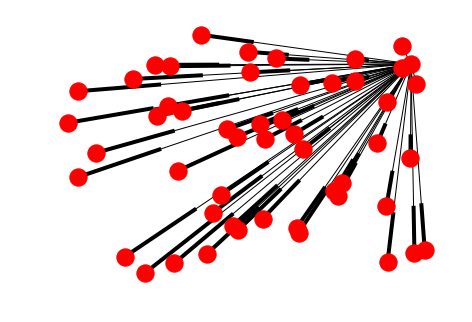

In [10]:
print_graph_from_dict(simulations[0])

In [11]:
def get_all_hinge_candidates(G):
    """
    Get all nodes which have 
    - no successors
    - (bonus) or successors do not have property "hinge" (exclude root)    
    
    Format of the graph G will be:
    
    G.add_node(col, hinge=split_point_as_float, hinge_parent=[parent_node])
    """
    candidates = []
    for node in G.nodes():
        if node == "root": 
            continue
        if len(G.successors(node)) == 0:
            candidates.append(node)
        else:
            # traverse through each one and check for attributes...
            check_hinge = [successor for successor in G.successors(node)
                           if 'hinge' in list(G.node[successor].keys())]
            if len(check_hinge) > 0:
                # add this node to candidate
                candidates.append(node)
    return candidates

def get_all_interaction_candidates(G):
    """
    
    Format of graph G will be
    
    G.add_node(colname, interaction=[colname1, colname2])
    """
    def check_valid_candidates(G, n1, n2):
        """
        Checks if a proposed interaction has already been created
        """
        check_set = set([n1, n2])
        for node_name in G.nodes():
            res = G.node[node_name].get("interaction", [])
            if set(res) == check_set:
                return False
        return True                
    
    candidates = []
    for node1 in G.nodes():
        if node1 == "root": 
            continue
        
        # propose a new candidate...this list is at most d*(d-1) in size.
        # generally smaller for reasons
        for node2 in G.nodes():
            if node2 == "root":
                continue
                
            # propose node1, node2 as a candidate
            # check if valid...
            if check_valid_candidates(G, node1, node2):
                candidates.append([node1, node2])
    
    return candidates

In [12]:
def get_all_hinge_parent(G):
    """
    Get all parents which are one level about possible candidates    
    
    this is used to spawn the equivalent remove call
    """
    # 1. get all possible hinge parents
    # 2. remove all hinge parents which have multiple children
    
    def check_valid_pair(child, all_hinge_parents):
        # filter out all children which are also a parent.
        all_parent = [parent for parent, child in all_hinge_parents]
        return False if child in all_parent else True
    
    all_hinge_parents = []
    for node in G.nodes():
        if 'hinge' in list(G.node[node].keys()):
            all_hinge_parents.append((G.node[node]['hinge_parent'], node))
    
    # filter out any candidates, where the proposed (parent, child) pair, has a child which is also a parent
    check = all_hinge_parents[:]
    all_hinge_parents = [(parent, child) for
                        parent, child in check if check_valid_pair(child, check)]
    return all_hinge_parents
    

def get_all_interaction_parents(G):
    """
    Get all parents of interactions in the graph
    
    this is used to spawn the equivalent remove call
    """
    def check_valid_pair(child, candidates):
        # filter out all children which are also a parent.
        all_parent = [d['interaction'] for d in candidates]
        flat_parents = [item for parent in all_parent for item in parent]
        return False if child in flat_parents else True
    
    candidates = []
    for node in G.nodes():
        if 'interaction' in list(G.node[node].keys()):
            candidates.append({'interaction': G.node[node]['interaction'], 'child':node})
    
    # sim to above, filter anything, where (parent, child) has a child, which is also a parent.
    check = candidates[:]
    all_candidates = [d for d in candidates if check_valid_pair(d['child'], check)]
    return all_candidates

In [13]:
# sense check....
# generate the base graph, where we have a the root node and all the base features...
G=nx.DiGraph()
G.add_node("root")

for col in base_names:
    # we can add node attributes, eg
    #G.add_node(col, attribute='here')
    G.add_node(col, node_type='base')
    G.add_edge("root", col)

print("There are no interaction parents: {}".format(len(get_all_interaction_parents(G)) == 0))
print("There are no hinge parents: {}".format(len(get_all_hinge_parent(G)) == 0))
print("There are linearly many hinge candidates: {}".format(len(get_all_hinge_candidates(G))))
print("There are exponential many interaction candidates: {}".format(len(get_all_interaction_candidates(G))))

There are no interaction parents: True
There are no hinge parents: True
There are linearly many hinge candidates: 50
There are exponential many interaction candidates: 2500


In [14]:
# start simulations!
def spawn_possible_actions(G):
    actions = []
    if get_all_interaction_parents(G):
        actions.append(("remove", "interact"))
    if get_all_hinge_parent(G):
        actions.append(("remove", "hinge"))
    if get_all_hinge_candidates(G):
        actions.append(("grow", "hinge"))
    if get_all_interaction_candidates(G):
        actions.append(("grow", "interact"))
    return actions

spawn_possible_actions(G)

[('grow', 'hinge'), ('grow', 'interact')]

In [15]:
def spawn_action_candidates(G, action, transform):
    if action == 'grow':
        if transform == 'hinge':
            return get_all_hinge_candidates(G)
        elif transform == 'interact':
            return get_all_interaction_candidates(G)
        else:
            raise Exception("invalid transform function")
    if action == 'remove':
        if transform == 'hinge':
            return get_all_hinge_parent(G)
        elif transform == 'interact':
            return get_all_interaction_parents(G)
        else:
            raise Exception("invalid transform function")
    else:
        raise Exception("invalid grow function")

In [16]:
def spawn_new_model(G):
    # to spawn a model, spawn possible actions:
    
    all_actions = spawn_possible_actions(G)
    action, transform = random.choice(all_actions)
    # this just returns the function that is randomly chosen.
    candidates = spawn_action_candidates(G, action, transform)
    selected_node = random.choice(candidates)
    
    G_prime = G.copy()        
    
    return {'action': action, 
            'transform': transform,
            'selected_node': selected_node}
    

In [17]:
# construct new model...
def spawn_new_pipeline(list_of_transforms):
    """
    list_of_transforms is a list of dictionaries    
    """
    pipeline = []    
    # we can add to pipeline and pop it off afterwards...
    # rather than overloading the graph!    
    for transform in list_of_transforms:
        # check of empty dictionary which is the first one
        if len(transform) == 0:
            continue
        
        if transform['action'] == 'grow':
            pipeline_name = "{}-{}-{}".format(
                transform['action'], transform['transform'], 
                ":".join(list(transform['selected_node']))
            )
            if transform['transform'] == 'hinge':
                pipeline_action = Hinge(mask=transform['selected_node'])
            elif transform['transform'] == 'interact':
                pipeline_action = Interaction(transform['selected_node'])
            pipeline.append((pipeline_name, pipeline_action))
        elif transform['action'] == 'remove':
            remove_pipeline_name = "{}-{}-{}".format(
                'grow', transform['transform'], 
                ":".join(list(transform['selected_node']))
            )
            pipeline = [(name, action) for name, action in pipeline if name != remove_pipeline_name]
    return pipeline


In [26]:
### spawn one pass...
new_model = spawn_new_model(G)
print("Chosen action/transform: {} {}".format(new_model['action'], new_model['transform']))
print("selected node(s): {}".format(new_model['selected_node']))

Chosen action/transform: grow hinge
selected node(s): base_13


In [27]:
graph_list = [G]
transform_list = [new_model]

In [28]:
new_pipeline = spawn_new_pipeline(transform_list)
new_pipeline

[('grow-hinge-b:a:s:e:_:1:3', Hinge(hinge=None, mask='base_13',
     psplit=<function error_on_split at 0x0000017C28BD79D8>, search_min=True))]

In [29]:
# baseline solution - vanilla pipeline
eval_pipeline(X=X_df)

Accuracy: 0.71


0.70999999999999996

In [30]:
# baseline solution - vanilla pipeline
eval_pipeline(additional_feats=new_pipeline, X=X_df)

Accuracy: 0.73


0.72999999999999998

Now we can perform MH, as long as we calculate the acceptance probabilities etc...